# Velocity gradient time series -- 4:1 Axisymmetric contraction

Flow: steady-state Newtonian at Re=1.

When streamlines are computed by ParaView, one column of the interpolated data is `"IntegrationTime"` which is used to rephrase the data as Lagrangian particles (instead of streamlines).

In [52]:
import numpy as np
from scipy.interpolate import interp1d
import pywt

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

folder = 'inputs/contraction'

files = [
    'tracer_y0.0035.csv'
]

output_file = 'inputs/contraction/scenario_contraction'

## Import velocity gradient data

In [53]:
times = []
gradUs = []
time_offset = 0.

for file in files:
    data = np.loadtxt(f'{folder}/{file}', delimiter=',', usecols=list(range(4,14)), skiprows=1) 
    times.append(data[:,-1] + time_offset)
    gradUs.append(data[:,:-1].reshape((len(data), 3, 3)))
    time_offset += data[-1,-1]

In [63]:
time = np.hstack(times)
gradU = np.vstack(gradUs)

# Remove trace
trgU = gradU[:,0,0] + gradU[:,1,1] + gradU[:,2,2]
gradU = gradU - trgU[:, None, None]/3*np.full_like(gradU, np.eye(3))

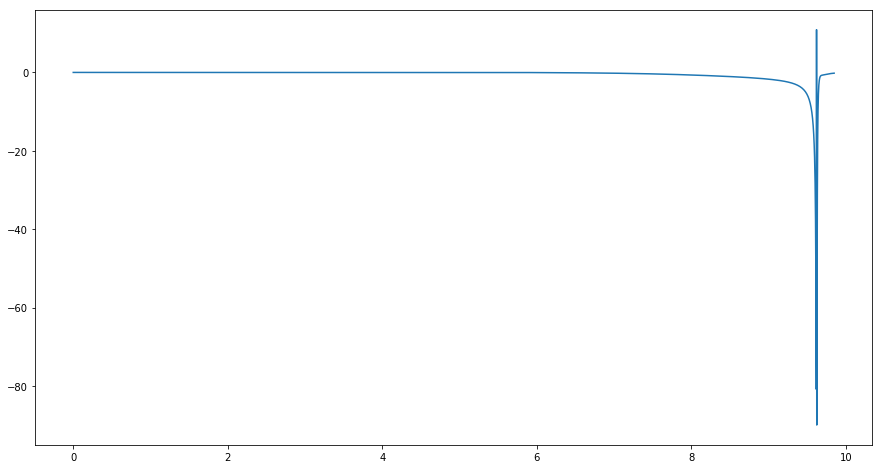

In [67]:
plt.plot(time, gradU[:,0,0])
plt.show()

In [68]:
# Rescale
factor = 0.1
gradU = factor*gradU
time = time/factor

## Analyse strain

Uniaxial elongation: 88.8%
Average Wi: 0.30493918785287555


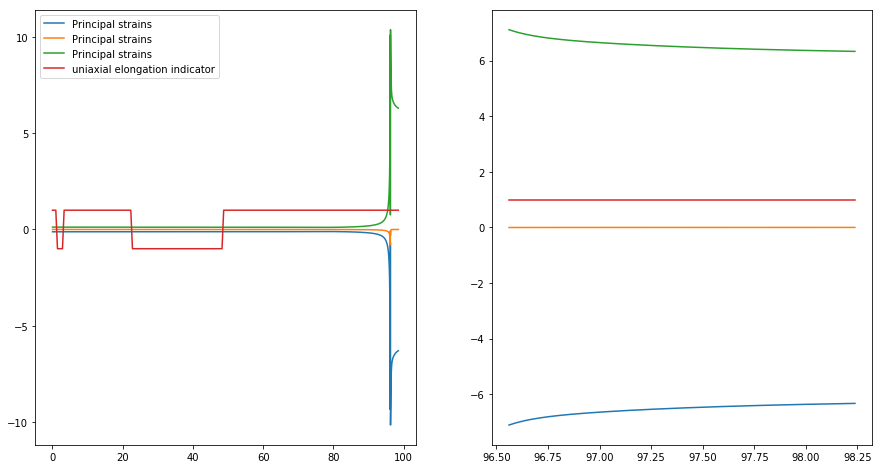

In [69]:
# Get principal values for the strain
D = 0.5*(gradU + np.transpose(gradU, axes=(0,2,1)))
strains = np.linalg.eigvalsh(D)

# Indicate whether strain is uni- of bi-axial
uniaxial = np.sign(strains[:,0]*strains[:,1]*strains[:,2])
print(f"Uniaxial elongation: {np.sum(uniaxial[uniaxial>0]/uniaxial.size*100):.3}%")
print(f"Average Wi:", np.sum(np.diff(time)*strains[:-1,2])/time[-1])

# Plot
fig, ax = plt.subplots(ncols=2)
ax[0].plot(time, strains, label='Principal strains')
ax[0].plot(time, uniaxial, label='uniaxial elongation indicator')
ax[0].legend()
ax[1].plot(time[300:500], strains[300:500], label='Principal strains')
ax[1].plot(time[300:500], uniaxial[300:500], label='uniaxial elongation indicator')
plt.show()

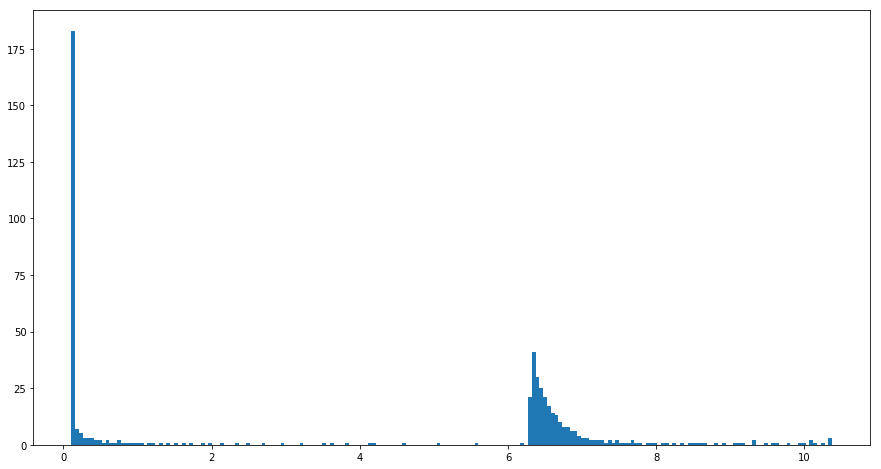

In [70]:
plt.hist(strains[:,2], bins=200)
plt.show()

In [112]:
np.savez_compressed(output_file, t=time, gradU=gradU_denoised)